In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import math

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut

from sklearn.datasets import load_iris, load_wine, fetch_olivetti_faces, load_digits, make_blobs, make_moons

# Lecture 7: Support Vector Machines (SVMs)

## 1. Introduction to SVMs

**Definition and Motivation:**  

Support Vector Machines (SVMs) are a class of supervised learning models used for classification and regression tasks. They are **max-margin** classifiers, meaning they find a decision boundary that maximizes the margin (distance) between different class examples. In essence, an SVM attempts to find the “best” separating hyperplane between two classes by maximizing the gap (margin) between them. This approach is rooted in statistical learning theory – SVMs were developed by Vladimir Vapnik and colleagues at AT&T Bell Labs and are grounded in Vapnik–Chervonenkis (VC) theory. The motivation for maximizing the margin comes from the intuition (and theoretical result) that a larger margin often leads to better generalization on unseen data. By pushing the decision boundary as far as possible from all training points, the classifier aims to be less sensitive to small perturbations or noise in the data. Indeed, being max-margin models, SVMs tend to be resilient to overfitting even in high-dimensional spaces and can handle some misclassified or noisy examples gracefully .

Throughout this lecture, we will focus on the **binary classification** setup, where we have two classes (which we will label +1 and –1 for convenience). The goal is to learn a classifier from a labeled training set that can accurately predict the class label of new, unseen examples. Formally, assume we are given a training dataset of $n$ points of the form $\{(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)\}$, where each feature vector $x_i \in \mathbb{R}^p$ and each label $y_i \in \{+1,\,-1\}$ indicates membership in one of two classes. Our objective is to find a classifier $f(x)$ that will correctly predict the labels for these and future points. In an SVM, this classifier is a linear decision function **(a hyperplane)** that separates the two classes with the maximum possible margin.

## 2. Mathematical Foundation

**Hyperplanes and Separating Data:**  

In a $p$-dimensional feature space, the most general form of an affine **hyperplane** can be written as an equation $w^T x + b = 0$, where $w \in \mathbb{R}^p$ is the normal vector (weight vector) perpendicular to the hyperplane, and $b \in \mathbb{R}$ is the offset (bias) term. This hyperplane defines a decision boundary that splits the space into two half-spaces: $w^T x + b > 0$ on one side and $w^T x + b < 0$ on the other. An SVM will assign one class to points falling in the region $w^T x + b > 0$ and the other class to points where $w^T x + b < 0$. For example, we might decide that if $w^T x + b \ge 0$ the prediction is +1, and if $w^T x + b < 0$ the prediction is –1. The equation $w^T x + b = 0$ thus defines the **decision boundary** between the two classes. The sign of $w^T x + b$ gives the predicted class ($\operatorname{sgn}(w^T x + b)$ is the classifier’s output).

A dataset is said to be **linearly separable** if there exists at least one hyperplane that can perfectly classify all training points into the +1 and –1 sides without error. In geometric terms, the two classes can be separated by a straight line (in 2D), a plane (in 3D), or a hyperplane in higher dimensions. When the data is linearly separable, many possible separating hyperplanes might exist. SVM’s key idea is to choose the one that **maximizes the margin** of separation, which intuitively corresponds to the most “robust” separator.

**Decision Boundaries and Margin:**  
Consider any hyperplane $w^T x + b = 0$ that separates the +1 and –1 classes. We can characterize how well this hyperplane separates the data by looking at the **margin**, which is the distance from the hyperplane to the nearest data point. Specifically, for a given hyperplane $(w,b)$ and a data point $x_i$, the signed distance of $x_i$ from the hyperplane is 
$$\frac{y_i (w^T x_i + b)}{\|w\|}$$ 
This is positive if the point is on the correct side and negative if it violates the classification. The margin achieved by the hyperplane on the dataset is the smallest distance of any training point to the hyperplane. To maximize this margin, we can rescale $w$ and $b$ such that the points closest to the hyperplane satisfy $|w^T x_i + b| = 1$. Under this convention, the two **margin boundaries** (the hyperplanes that touch the closest points of each class) are defined by: 

- $w^T x + b = 1$ for the +1 class boundary, and 
- $w^T x + b = -1$ for the –1 class boundary. 

All +1 class points lie on or above $w^T x + b = 1$, and all –1 class points lie on or below $w^T x + b = -1$. The region between these two parallel hyperplanes is the **margin** (no training points fall inside this region for a fully separable dataset). Geometrically, the distance between the two margin boundaries is $\frac{2}{\|w\|}$. Therefore, maximizing the margin is equivalent to minimizing $\|w\|$. SVM optimizes this criterion with constraints ensuring all points are on the correct side of the margin.

<img width=400px, src="https://upload.wikimedia.org/wikipedia/commons/7/72/SVM_margin.png"> 
*Figure: Illustration of the maximum-margin hyperplane for a binary SVM in a 2D feature space. 

The red line is the separating hyperplane $w^T x + b = 0$. The blue and green points belong to two classes. The parallel dashed lines (in blue for $w^T x + b = 1$ and in green for $w^T x + b = -1$) show the boundaries of the margin. The vectors $w$ (normal to the hyperplane) and the margin distance $2/\|w\|$ are indicated. The points that lie exactly on the margin boundaries are the **support vectors** (circled in the figure); these points effectively determine the position of the optimal hyperplane.* 

The **support vectors** are the training examples that lie closest to the decision boundary – in fact, they satisfy $|w^T x_i + b| = 1$ at optimum. These points “support” or define the maximum-margin hyperplane; if they were removed or moved slightly, the optimal hyperplane would change. Points further away from the boundary (inside their respective class regions) do not directly influence the final solution. An important consequence of this is that the solution to an SVM is often sparse in terms of support vectors – only a subset of training points end up determining the decision boundary.

## 3. Optimization Problem

With the geometric picture in mind, we now formulate the SVM training as an optimization problem. We will first consider the **hard-margin SVM**, which assumes the data is linearly separable with no misclassification, and then extend it to the more general **soft-margin SVM** that allows some classification errors or overlap.

**Hard-Margin SVM (Separable Case):**  
For linearly separable data, the conditions for a hyperplane $(w, b)$ to correctly classify all points with a margin of at least 1 can be written as constraints: for every $i$ in $1,\dots,n$,

- If $y_i = +1$, then $w^T x_i + b \ge 1$ (the point lies on the +1 side of the margin boundary),  
- If $y_i = -1$, then $w^T x_i + b \le -1$ (the point lies on the –1 side of the margin boundary).  

These can be compactly written as a single inequality: 
$$ y_i (w^T x_i + b) \ge 1, \quad \forall\, i = 1,\dots,n. \tag{1} $$ 
This inequality ensures every point lies on the correct side of the margin and at least distance 1 from the decision boundary. Our goal is to find the hyperplane that satisfies these constraints while maximizing the margin $2/\|w\|$. Equivalently, we minimize $\tfrac{1}{2}\|w\|^2$ (using $\tfrac{1}{2}\|w\|^2$ is mathematically convenient and leads to the same solution as minimizing $\|w\|$). We can ignore the factor of 2 in the margin since scaling $w$ does not change the location of the hyperplane given the constraints in (1).

Putting it together, we have the **primal optimization problem** for the hard-margin SVM: 

$$
\begin{aligned}
\text{minimize}_{\,w,\,b} \quad & \frac{1}{2}\,\|w\|^2, \\
\text{subject to} \quad & y_i (w^T x_i + b) \ge 1, \quad i=1,\dots,n~.
\end{aligned}
$$

This is a convex optimization problem (specifically, a Quadratic Program, since the objective is quadratic and constraints are linear). Because it is convex, any local optimum is a global optimum. Solving this optimization yields the weight vector $w$ and bias $b$ that define the maximum-margin hyperplane. The resulting classifier is $f(x) = \operatorname{sgn}(w^T x + b)$, which predicts +1 if $w^T x + b \ge 0$ and –1 otherwise.

However, real-world data is often **not linearly separable** – there might be no hyperplane that can perfectly classify all points, or forcing a perfect separation might lead to overfitting in the presence of noise or outliers. To handle such cases, SVMs introduce a soft-margin through **slack variables**.

**Soft-Margin SVM (Non-separable Case):**  
To allow some points to violate the margin constraint (or even be misclassified), we introduce nonnegative slack variables $\{\zeta_i\}$ for each data point. The constraint (1) is relaxed to: 
$$ y_i (w^T x_i + b) \ge 1 - \zeta_i, \quad \zeta_i \ge 0, \quad \forall i. $$
Here $\zeta_i$ measures how much the $i$-th point violates the ideal margin condition. If $\zeta_i = 0$, the point lies outside or on its correct margin boundary. If $0 < \zeta_i < 1$, the point is inside the margin (closer to the boundary than it should be, but still on the correct side of the hyperplane). If $\zeta_i > 1$, the point is misclassified (it lies on the wrong side of the decision boundary). To penalize violations, the objective function is modified to include a penalty term proportional to the total slack. This leads to the **soft-margin optimization problem**:

$$
\begin{aligned}
\text{minimize}_{\,w,\,b,\,\{\zeta_i\}} \quad & \frac{1}{2}\,\|w\|^2 + C \sum_{i=1}^n \zeta_i, \\
\text{subject to} \quad & y_i (w^T x_i + b) \ge 1 - \zeta_i, \;\; \zeta_i \ge 0, \quad i=1,\dots,n~.
\end{aligned}
$$

The constant $C > 0$ is a regularization parameter that controls the trade-off between maximizing the margin and minimizing classification errors. Larger $C$ puts more weight on the slack penalty (thus heavily discouraging misclassification, at the cost of a smaller margin), while a smaller $C$ allows a wider margin at the expense of potentially more margin violations. In the limit $C \to \infty$, this approach approximates the hard-margin SVM if the data is separable. On the other hand, if $C$ is too small, the classifier might ignore important data points (allowing too many violations) and underfit. Choosing $C$ appropriately is important in practice.

**Lagrange Duality and KKT Conditions:**  
The constrained optimization problems above are typically solved using Lagrange duality. We introduce Lagrange multipliers $\alpha_i \ge 0$ for each constraint $y_i(w^T x_i + b) \ge 1 - \zeta_i$, and (for soft margin) additional multipliers $\mu_i \ge 0$ for the constraints $\zeta_i \ge 0$. Without going into all the algebraic details, the main idea is to form the Lagrangian:
$$ \mathcal{L}(w,b,\zeta,\alpha,\mu) = \frac{1}{2}\|w\|^2 + C\sum_{i}\zeta_i - \sum_{i}\alpha_i\big(y_i(w^T x_i + b) - 1 + \zeta_i\big) - \sum_i \mu_i \zeta_i, $$
and then set derivatives to zero (Karush–Kuhn–Tucker optimality conditions) to find the optimum. The KKT conditions yield some crucial insights:

- **Stationarity:** Setting $\partial \mathcal{L}/\partial w = 0$ gives 
  $$ w = \sum_{i=1}^n \alpha_i y_i x_i. $$ 
  That is, the optimal weight vector *can be expressed as a linear combination of the training points*, where each point $x_i$ is weighted by $\alpha_i y_i$. Only points with $\alpha_i > 0$ appear in this sum – these points are precisely the support vectors. Points not acting as support vectors have $\alpha_i = 0$ and thus do not contribute to $w$. Similarly, setting $\partial \mathcal{L}/\partial b = 0$ gives $\sum_{i} \alpha_i y_i = 0$, a condition that ensures the correct positioning of the hyperplane.

- **Complementary Slackness:** For each $i$, the KKT conditions include $\alpha_i [\,y_i(w^T x_i + b) - 1 + \zeta_i\,] = 0$ and $\mu_i \zeta_i = 0$. Intuitively, this means that if a point is not on the margin boundary (i.e. $y_i(w^T x_i + b) > 1 - \zeta_i$), then the corresponding $\alpha_i$ must be zero (the constraint is inactive). Only the points *exactly* on the margin or violating it have $\alpha_i > 0$. In other words:  
  – If $y_i(w^T x_i + b) > 1$ (point well outside margin), then $\alpha_i = 0$.  
  – If $y_i(w^T x_i + b) = 1$ (point on margin boundary, a support vector), then $\alpha_i$ can be between 0 and $C$.  
  – If $y_i(w^T x_i + b) < 1$ (point inside margin or misclassified), then at the optimum $\alpha_i = C$ (in the hard-margin case this situation can’t happen for optimum, but in soft-margin it can, and $\alpha_i$ hits its maximum allowed value).  

From these conditions, we conclude that the solution is characterized by support vectors with $0 < \alpha_i \le C$ (for those exactly on the boundary, $\alpha_i$ will be in this range, and for misclassified points $\alpha_i$ often hits the upper bound $C$). The weight vector is determined by those support vectors: $w = \sum_{i \in SV} \alpha_i y_i x_i$ , and the bias term $b$ can be recovered by using any support vector $x_j$ that lies on the margin and satisfying $y_j(w^T x_j + b) = 1$ (solve for $b$).

**Dual Optimization Problem:**  
Applying the method of Lagrange multipliers and eliminating $w$ and $b$ yields the **dual form** of the SVM optimization. In the dual, we maximize a function of the $\alpha_i$ (or sometimes noted $c_i$) subject to certain constraints. For the soft-margin case, the dual problem can be written as:

$$
\begin{aligned}
\text{maximize}_{\alpha_1,\dots,\alpha_n} \quad & \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j\,y_i y_j\,(x_i \cdot x_j), \\
\text{subject to} \quad & 0 \le \alpha_i \le C, \quad \forall i, \\
& \sum_{i=1}^n \alpha_i y_i = 0~.
\end{aligned}
$$ 

This is a quadratic programming (QP) problem in variables $\alpha_i$. Importantly, notice that the training vectors $x_i$ only appear inside **dot products** $(x_i \cdot x_j)$. The advantage of the dual formulation is twofold: (1) It provides a way to handle the constraints efficiently, and (2) as we will see next, it enables the use of **kernel functions** to extend SVMs to nonlinear decision boundaries. The solution $\{\alpha_i\}$ from the dual can be used to recover $w$ (as above) and $b$. Typically, after solving the dual, we identify the support vectors (those with $\alpha_i > 0$) and use one of them on the margin to compute $b$. The final decision function can be written in terms of the dual variables as: 

$$ f(x) = \operatorname{sgn}\!\Big(\sum_{i=1}^n \alpha_i y_i (x_i \cdot x) + b\Big), $$ 

which depends on the input $x$ only through dot products with the support vectors. 

## 4. Dual Formulation and the Kernel Trick

One of the most powerful features of SVMs is that by working in the dual (where training data appears via dot products), we can apply a transformation to the input features to handle cases where the relationship between classes is not linear. The **kernel trick** allows SVMs to perform **nonlinear** classification by implicitly mapping the data into a higher-dimensional feature space where a linear separator might exist.

**Kernel Trick Concept:**  
Suppose our data is not linearly separable in the original input space $\mathbb{R}^p$. We can apply a **feature mapping** $\varphi: \mathbb{R}^p \to \mathbb{R}^P$ that transforms the data into a new space of dimension $P$ (which could be much larger than $p$, even infinite). In this new space, we hope the classes become linearly separable. The dual SVM only requires dot products of data points: instead of $(x_i \cdot x_j)$, we would have $(\varphi(x_i) \cdot \varphi(x_j))$. A **kernel function** $K(x_i, x_j)$ is defined to compute exactly this dot product in the feature space: 
$$ K(x_i, x_j) = \varphi(x_i) \cdot \varphi(x_j). $$
The kernel trick is to perform SVM training (and classification) using $K(x_i, x_j)$ in place of explicit dot products, thereby never needing to compute $\varphi(x)$ explicitly. As long as we can compute $K(x_i, x_j)$ efficiently, we can work in the high-dimensional space implicitly. This allows SVMs to fit a maximum-margin hyperplane in a transformed feature space, which corresponds to a **nonlinear** decision boundary in the original space.

It’s important to note that working in a very high-dimensional feature space can increase the risk of overfitting if the number of training examples is not sufficient. However, SVMs often still perform well due to the regularization effect of margin-maximization, and many common kernels have embedded smoothness constraints.

**Common Kernel Functions:**  
There are many kernels available, each corresponding to a different choice of feature space $\varphi(x)$. Some widely used kernel functions in SVMs are:

- **Polynomial Kernel:** $K(x_i, x_j) = (x_i \cdot x_j + r)^d$. This corresponds to mapping the original features into all monomials of degree $d$ (including cross-terms up to $d$). For example, a quadratic polynomial kernel ($d=2$) in two variables $(a,b)$ would map $(a,b)$ to $(a^2, ab, b^2, a, b, 1)$ if $r=1$ (inhomogeneous polynomial including lower-degree terms). Setting $r=0$ gives a homogeneous polynomial kernel $K(x_i, x_j) = (x_i \cdot x_j)^d$. The polynomial kernel allows learning curved boundaries. Note that $d=1$ with $r=0$ simply gives the linear kernel (no mapping at all).

- **Gaussian Radial Basis Function (RBF) Kernel:** $K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)$ for some $\gamma > 0$. This is one of the most popular kernels. The RBF kernel maps the data into an (infinite-dimensional) feature space and can handle very complex decision boundaries. Intuitively, it places a bump (like a Gaussian) around each training point in feature space; the parameter $\gamma$ controls the width of these bumps (higher $\gamma$ means narrower bumps). The RBF kernel can separate data that is not linearly separable by essentially creating nonlinear combinations of features based on distance. It’s a universal approximator, meaning with the right parameters it can fit very complex patterns.

- **Sigmoid Kernel:** $K(x_i, x_j) = \tanh(\kappa\, x_i \cdot x_j + c)$. This kernel comes from the neural network field (it’s essentially a 2-layer perceptron’s activation function). For certain parameter settings, it was historically used as an approximate kernel. However, unlike polynomial or RBF, the sigmoid kernel does not always satisfy all conditions to be a valid kernel for all $\kappa, c$ (it doesn’t always yield a positive semi-definite Gram matrix). In practice, it can behave like a neural network with one hidden layer.

- **Other kernels:** There are many specialized kernels for particular data types – e.g., string kernels for text sequences, graph kernels for structured data, etc. As long as the kernel function corresponds to an inner product in some space (Mercer’s condition), an SVM can utilize it.

Using a kernel in the SVM dual, our decision function becomes: 
$$ f(x) = \operatorname{sgn}\!\Big(\sum_{i=1}^n \alpha_i y_i\, K(x_i, x) + b\Big). $$
The training algorithm finds the coefficients $\alpha_i$ for support vectors as before, but now the similarity between a new point $x$ and a support vector $x_i$ is computed via $K(x_i, x)$ instead of a dot product. This approach allows SVMs to construct very flexible decision boundaries. For example, an SVM with an RBF kernel can generate highly nonlinear boundaries in the input space, effectively creating regions that separate classes in a complex way. Conversely, in the kernel’s feature space (which could be infinite-dimensional), that same decision boundary is a flat hyperplane.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fe/Kernel_Machine.svg">
*Figure: Illustration of the kernel trick. **Left:** In the original 2D input space, the red curve represents a nonlinear decision boundary separating two classes (white points). This problem is not linearly separable in 2D. **Right:** By mapping the data into a higher-dimensional feature space (in this example, 3D), the data becomes linearly separable, and the SVM finds a linear decision boundary (red line) in that space. This linear boundary corresponds to the curved boundary in the original space. Using a kernel function (here $\varphi(a,b)=(a,b,a^2+b^2)$ for illustration) allows the SVM to find such nonlinear separators without explicitly computing the 3D coordinates for every point.

## 5. Practical Considerations

**Implementation and Computational Complexity:**  
Training an SVM involves solving a convex optimization (QP) problem. The standard QP solvers can be slow when $n$ (number of training examples) is large, as they have worst-case complexity that grows polynomially with $n$ (often between $O(n^2)$ and $O(n^3)$ in practice for kernel SVMs) ([Training complexity of Linear SVM - Stack Overflow](https://stackoverflow.com/questions/16585465/training-complexity-of-linear-svm#:~:text=Training%20complexity%20of%20nonlinear%20SVM,following%20papers%20are%20good%20references)). Modern SVM implementations use optimization tricks to handle reasonably large datasets. One popular method is **Sequential Minimal Optimization (SMO)**, which breaks the large QP into a series of smallest possible QP problems (involving two variables at a time) that can be solved analytically. SMO (implemented in the widely used LIBSVM library) is very efficient for medium-sized data, but training can become impractical for extremely large $n$ (say, millions of points). In fact, the runtime of the SVM training (with non-linear kernels) typically scales at least quadratically with the number of samples, and may become infeasible beyond tens of thousands of samples ([SVC — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#:~:text=C)). If you have a very large dataset, you might consider using a **linear SVM** solver (like LIBLINEAR) or approximate kernel methods (e.g., the **Nyström method** for kernel approximation) ([SVC — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#:~:text=C)).

Memory can also be a concern: a kernel SVM must compute and store the kernel matrix of size $n \times n$ in the worst case, which can be memory-intensive for large $n$. **Sparse data** (e.g., text with bag-of-words features) and using linear or low-degree polynomial kernels can alleviate some of these issues, as specialized solvers can handle them more efficiently.

Despite these costs, SVMs are quite practical for datasets of moderate size, and packages like scikit-learn’s `SVC` (which is based on LIBSVM) make it easy to train SVMs. For example, scikit-learn’s documentation notes that the SVM `fit` time complexity is at least quadratic in $n$ ([SVC — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#:~:text=C)), and it recommends using linear or stochastic methods for very large datasets.

**Pros of SVMs:**  
- **Effective in high dimensions:** SVMs work well even when the number of features is large, sometimes even larger than the number of samples (they are less susceptible to the curse of dimensionality than some other models, thanks in part to the regularization from the margin). They have been successfully used in text classification where feature spaces can have tens of thousands of dimensions ([Support vector machine - Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#:~:text=,true%20for%20image%20segmentation%20systems)).  
- **Robust to overfitting:** The maximum-margin principle (and the use of regularization via $C$) means SVMs have good generalization performance. The theoretical underpinning from VC dimension theory suggests that maximizing the margin corresponds to controlling complexity and avoiding overfitting. In practice, SVMs often perform reliably, especially in cases with clear class separation. They are also relatively robust to a few mislabeled examples (outliers) since those would need a large slack penalty and the optimizer may choose to ignore them if $C$ is not too large.  
- **Convex optimization problem:** The training objective is convex, so we don’t have to worry about local minima. This contrasts with neural networks, for example, which have non-convex loss surfaces. With SVMs, if a solution exists, the optimization will find the global optimum.  
- **Flexibility with kernels:** By choosing appropriate kernel functions, SVMs can model a wide variety of decision boundaries. This gives them the power to tackle nonlinear problems by implicitly mapping data to higher dimensions. One can even design custom kernels for structured data (strings, trees, graphs) to apply SVMs in those domains.  
- **Sparsity of solution:** The fact that only support vectors determine the classifier can make the model memory-efficient at prediction time. Once trained, you only need to store and compute over the support vectors, not the entire dataset.

**Cons of SVMs:**  
- **Computational cost:** As mentioned, SVM training can be slow for large datasets (both in time and memory). Scaling SVMs to very large $n$ is challenging – algorithms like stochastic gradient descent or specialized libraries are needed for millions of points. For extremely large-scale problems, other classifiers (like neural networks or simpler linear models) might be more suitable.  
- **Choice of kernel and parameters:** SVMs require selecting a kernel and tuning parameters like $C$ and kernel-specific parameters (e.g., $\gamma$ for RBF, degree for polynomial). The performance can be quite sensitive to these choices, and finding the best combination often requires cross-validation or grid search, which can be time-consuming. Poor choices can lead to overfitting (e.g., an RBF kernel with very large $\gamma$ can overfit by creating very tight decision boundaries around points) or underfitting (e.g., too small $\gamma$ or too large $C$ may underfit).  
- **Non-probabilistic output:** SVMs natively produce a hard classification (just the sign of the decision function). They do not provide probability estimates for classes out-of-the-box. It is possible to calibrate an SVM’s outputs to probabilities (for instance, using Platt scaling which fits a logistic regression to the SVM scores), but this is an additional step. If you need direct probability outputs for your task, you have to account for this.  
- **Interpretability:** While linear SVMs provide weights for features (which can give some insight into feature importance), kernel SVMs are less interpretable because the decision boundary is in a high-dimensional space. It’s not as straightforward to explain why a particular classification was made, compared to, say, a decision tree or a logistic regression with visible coefficients. Some work has been done on extracting insights from the support vectors or constructing pre-image of support vectors in input space, but generally SVMs are considered black-box in terms of interpretability.  
- **Scaling to multiclass:** SVMs are inherently binary classifiers. To handle multiple classes ($k$ classes), one typically uses strategies like **one-vs-rest** (train $k$ separate SVMs, each distinguishing one class vs all others) or **one-vs-one** (train $\binom{k}{2}$ SVMs for every pair of classes and use a voting or max-win strategy). Scikit-learn’s SVC, for instance, uses a one-vs-one scheme by default for multiclass problems ([SVC — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#:~:text=The%20implementation%20is%20based%20on,transformer%20or%20other%20%20639)). These approaches work well but increase computational complexity (especially one-vs-one, which involves many classifiers). There are also “all-in-one” formulations of multiclass SVMs, but they are more complex to implement.  

In summary, SVMs are a powerful tool with strong theoretical backing and good performance on a variety of tasks, but they require careful parameter tuning and are best suited for medium-sized problems. For very large-scale problems or when rapid training is required, one might consider alternatives (or use linear SVM variants). On the other hand, for problems with moderate data where accuracy is paramount and you can afford the computation, SVMs (especially with an RBF kernel) are often a top choice.

**Comparison with Other Classification Algorithms:**  
- Compared to **logistic regression**, an SVM with a linear kernel can achieve similar results; both find a linear separator, but logistic regression optimizes log-loss (maximum likelihood) while SVM optimizes hinge loss with a margin. Logistic regression provides probabilistic outputs and is easier to update online, whereas SVM focuses on the boundary cases (support vectors) and might be more robust to outliers (due to the margin). In practice, for linearly separable data, a hard-margin SVM and a perceptron will both find a separating hyperplane; the SVM’s choice (max-margin) is usually the one with better generalization.  
- Compared to **decision trees** or rule-based models, SVMs generally produce more complex decision boundaries (especially with kernels) that are not human-interpretable, but they can achieve higher accuracy in continuous high-dimensional spaces. Decision trees handle multiclass and feature interactions natively and are fast to train, but an SVM with a kernel might capture subtle nonlinear relations that a shallow decision tree might miss (boosted trees or random forests narrow that gap with ensembling).  
- Compared to **neural networks**, SVMs require far less training data to get a good model in many cases (because of the strong regularization). Neural networks are more flexible with architecture and naturally handle multiclass and multi-output scenarios, but they need careful training (learning rates, epochs) and large datasets. For moderate-sized data and a well-chosen kernel, an SVM can often match or outperform a neural network, especially in the era before deep learning. However, for very large datasets or complex tasks like image recognition, deep neural nets have surpassed SVMs in accuracy (historically, SVMs were used for digit classification in MNIST and performed very well with appropriate kernels).  

In practice, it often makes sense to try a linear model (like logistic regression), an SVM, and perhaps a tree-based model to see which works best for your problem, as each has its own biases and strengths.


### Key Takeaways:
- SVMs find a hyperplane that separates classes with the maximum margin, leading to a robust classifier with good generalization ([Support vector machine - Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#:~:text=Geometrically%2C%20the%20distance%20between%20these,displaystyle)) ([Support vector machine - Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#:~:text=We%20can%20put%20this%20together,to%20get%20the%20optimization%20problem)).
- By solving a convex optimization problem with constraints, SVMs achieve a globally optimal solution characterized by support vectors ([Support vector machine - Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#:~:text=An%20important%20consequence%20of%20this,are%20called%20support%20vectors)) ([Support vector machine - Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#:~:text=Image%3A%20,n%7Dc_%7Bi%7Dy_%7Bi%7D%5Cmathbf%20%7Bx%7D%20_%7Bi)).
- The dual formulation enables the use of kernel functions to handle non-linearly separable data by implicitly mapping it to high-dimensional feature spaces ([Support vector machine - Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#:~:text=nonlinear%20classifiers%20by%20applying%20the,in%20the%20original%20input%20space)) ([Support vector machine - Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#:~:text=,displaystyle%20k%28%5Cmathbf)).
- Common kernels (polynomial, RBF, sigmoid, etc.) provide flexibility to model various types of decision boundaries ([Support vector machine - Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#:~:text=,mathbf)) ([Support vector machine - Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#:~:text=,and%20%20637%20Image)).
- In practice, SVMs require careful tuning of hyperparameters and can be computationally intensive for large datasets ([Training complexity of Linear SVM - Stack Overflow](https://stackoverflow.com/questions/16585465/training-complexity-of-linear-svm#:~:text=Training%20complexity%20of%20nonlinear%20SVM,following%20papers%20are%20good%20references)) ([SVC — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#:~:text=C)), but they remain a powerful and widely-used tool for classification problems. By understanding the mathematical foundation and geometric intuition, one can apply SVMs more effectively and interpret their results. 

## 6. Examples

**Example 1: Maximum Margin on a Simple Linearly Separable Dataset**  
Imagine we have a small dataset of two classes that are linearly separable. We can generate such a dataset and train a linear SVM to find the separating hyperplane. For instance:

In [4]:
X = np.array([[2, 3], [3, 3], [3, 4],    # Class +1
              [6, 8], [7, 7], [8, 8]])   # Class -1
y = np.array([1, 1, 1, -1, -1, -1])      # Labels

model = SVC(kernel='linear', C=1e6)  # large C for nearly hard-margin
model.fit(X, y)

print("w =", model.coef_)
print("b =", model.intercept_)
print("Support vectors:\n", model.support_vectors_)

w = [[-0.28584273 -0.28554302]]
b = [2.99960039]
Support vectors:
 [[6. 8.]
 [7. 7.]
 [3. 4.]]


Here we manually created 3 points of class +1 around (2,3) and 3 points of class -1 around (7,8) which are clearly separable by a line. We train an SVM with a linear kernel (`kernel='linear'`). By setting $C$ very high (1e6), we are effectively not allowing any slack, forcing a hard margin solution. The output `w` and `b` will be the learned hyperplane parameters (note: scikit-learn uses the form $w^T x + b = 0$ for decision boundary, consistent with our notation). The support vectors printed are the points that lie on the margin. If you run this code, you might see that some points in each class are identified as support vectors – those are the ones exactly on the margin boundaries.

We can verify the margin conditions: plugging the support vectors into $w^T x + b$ should give approximately +1 or -1. Any non-support vector will give a value greater than 1 or less than -1, indicating it lies outside the margin region. This example reinforces that only a subset of points (the support vectors) define the classifier.

**Example 2: Nonlinear Separation with Kernel (XOR problem)**  
To illustrate the power of kernels, consider the classic XOR problem. XOR is not linearly separable in the original 2D space: the data points $(0,0)$ and $(1,1)$ belong to class 0, while $(0,1)$ and $(1,0)$ belong to class 1 (i.e., points with exactly one of the coordinates being 1). No single straight line can separate the 0’s and 1’s here. We’ll see that a linear SVM fails, but an SVM with an RBF kernel succeeds:

In [5]:
# XOR dataset
X = [[0,0],
     [0,1],
     [1,0],
     [1,1]]
y = [0, 1, 1, 0]  # Class labels for XOR

# Linear kernel SVM
clf_linear = SVC(kernel='linear', C=1.0)
clf_linear.fit(X, y)
print("Linear kernel predictions:", clf_linear.predict(X))

# RBF kernel SVM
clf_rbf = SVC(kernel='rbf', gamma='auto', C=1.0)
clf_rbf.fit(X, y)
print("RBF kernel predictions:", clf_rbf.predict(X))

Linear kernel predictions: [1 1 1 1]
RBF kernel predictions: [0 1 1 0]


We see that the linear SVM predicts the same class (1) for all points – it cannot separate XOR and essentially ends up drawing a line that misclassifies two of the four points. In contrast, the SVM with the Gaussian RBF kernel correctly learns the XOR pattern (its predictions match the true labels `[0, 1, 1, 0]`). The RBF kernel effectively transformed the feature space (in this case, one can show that mapping $[a,b] \mapsto [a, b, ab]$ makes XOR linearly separable) so that the classes become separable. The ability to handle such XOR-like patterns is a testament to the kernel trick’s power.

**Example 3: Using SVM on a Real Dataset (Iris)**  
For a more practical example, consider the famous Iris flower dataset (a built-in dataset in scikit-learn). It’s a multiclass problem (3 species of iris), but we can still use SVM. We’ll train an SVM with an RBF kernel and see its accuracy:

In [7]:
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target  # features and multi-class labels (0,1,2)
# Split into train and test for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train SVM with RBF kernel
svc = SVC(kernel='rbf', gamma='scale', C=1.0)
svc.fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")
print("Number of support vectors for each class:", svc.n_support_)

Test accuracy: 1.00
Number of support vectors for each class: [ 5 24 20]


## Example 4: A step by step synthetic example

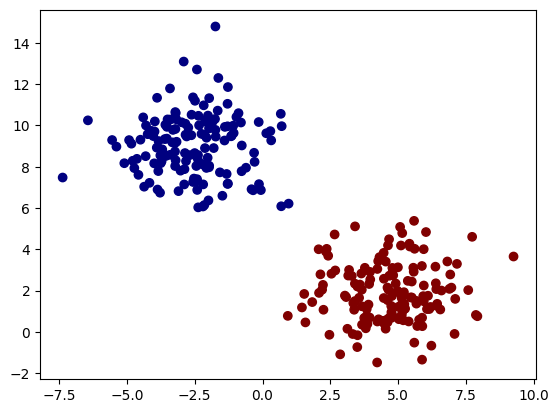

In [54]:
X, y = make_blobs(n_samples=300, centers=2, cluster_std=1.5, random_state=42)
plt.scatter(X[:,0],X[:,1], c=y, cmap='jet')

Now, look at the picture above. We need a separating hyperplane given by a pair $(w,b)$ where $w\in\mathbb{R}^n$ and $b\in \mathbb{R}$ such that

$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1 $ for every $i=1,\ldots,N$

If this condition is satisfied then the gap between the separating hyperplanes becomes $\frac{2}{\|w\|}$. Thus maximizing the gap becomes equivalent to finding a suitable vector $w$ with the smallest norm.

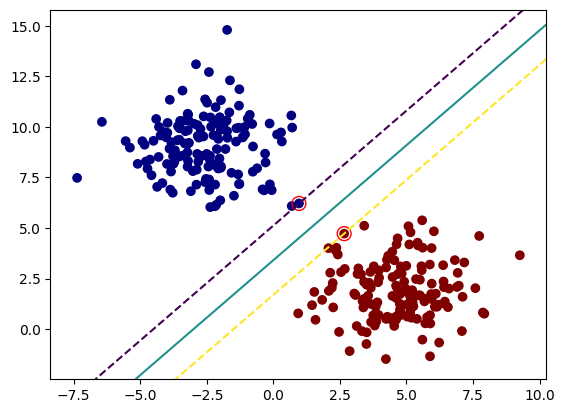

In [57]:
model = SVC(kernel="linear",C=1.05)
model.fit(X,y)

plt.scatter(X[:,0],X[:,1],c=y,cmap='jet')
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    plot_method="contour",
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="red"
)

## 1.2 Hard Margin vs Soft Margin

The standard SVM model operates on the assumption that the data is separable. This situation is described by having a **hard margin**.

In cases where the data is not completely separable, we might allow some mixing within the margin. In these cases, we use a **soft margin** and we would like to allow some points being inside the margin. We call this situation as SVM classifier with *a soft margin*.  In mathematical terms, we do not strictly insist on the condition

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1 $$

and allow points transgress the boundary with some error

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1-\xi_i $$

But this time we optimize

$$ \|\mathbf{w}\| + C \sum_{i=1}^N \xi_i^2 $$

where $C$ is a hyper-parameter we tune for the application at hand.

Please read [these lecture notes](http://fourier.eng.hmc.edu/e161/lectures/svm/node5.html) and [sklearn SVM with soft margins](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html) from the [sklearn documentation](https://scikit-learn.org/stable/user_guide.html).

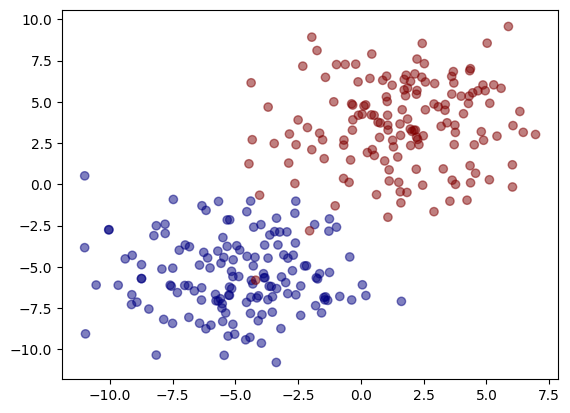

In [62]:
X,y = make_blobs(n_samples=300, centers=2, cluster_std=2.5)
plt.scatter(X[:,0],X[:,1],c=y,cmap='jet',alpha=0.5)

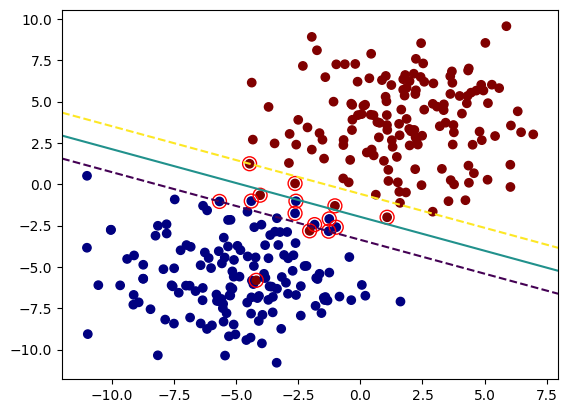

In [63]:
model = SVC(kernel="linear",C=1.0)
model.fit(X,y)

plt.scatter(X[:,0],X[:,1],c=y, cmap='jet')
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    plot_method="contour",
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="red",
)

## 1.3 The Kernel Trick

There is another parameter that we can play with. That is the inner product we work with. 

Recall that our method heavily relies on the inner product since we either minimize $\|w\|$ subject to 

$y^{(i)}(x^{(i)}\cdot w - b) \geq 0 $

or minimizing the total hinge loss function

$\lambda \|w\| + \sum_i \max(0,1-y^{(i)}(x^{(i)}\cdot w - b))$

We can also use different inner products other than the ordinary Euclidean one:

$x\cdot y = \sum_i x_i y_i$

This method is equivalent to embedding $\mathbb{R}^n$ into another larger $\mathbb{R}^m$ via a (non)linear embedding and then using the ambient Euclidean product in $\mathbb{R}^m$.  This is useful when the original dataset is not linearly separable.

There are three main classes of kernels you can use

* linear
* polynomial
* radial basis function (RBF)

You can read the documentation [here](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html).

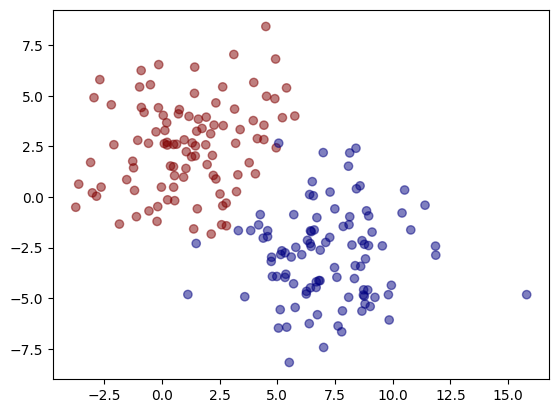

In [67]:
X,y = make_blobs(n_features=2, n_samples=200, centers=2, cluster_std=2.25)
plt.scatter(X[:,0],X[:,1],c=y,cmap='jet',alpha=0.5)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.66)

model = SVC(kernel="poly",C=1.0,degree=2)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.9558823529411765

## 1.4 Multiclass SVM

Above we worked with SVM with binary classification. However, SVM is versatile enough to work with multiclass classification problems.

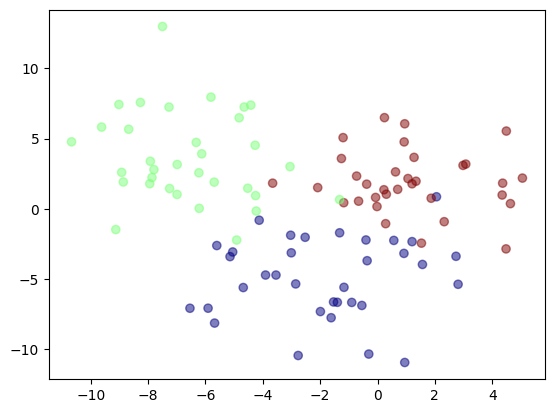

In [69]:
X,y = make_blobs(centers=3, cluster_std=2.5, n_features=200)
plt.scatter(X[:,0],X[:,1],c=y,cmap='jet',alpha=0.5)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.66)

model = SVC(kernel="linear")
model.fit(X_train,y_train)
model.score(X_test,y_test)

1.0